lmfit Version
===

Extracting a signal from two datasets.
---
Below we simulate two experiments.

Experiment1:
- has a gaussian signal
- and a falling background that goes as $exp^{-x/\lambda}$

Experinemt2:
- has the same gaussian signal component
- and a background that goes as $x^n$, where $n$<0

In [6]:
%pip install lmfit

  Using cached lmfit-1.3.4-py3-none-any.whl.metadata (8.8 kB)
  Using cached asteval-1.0.7-py3-none-any.whl.metadata (4.9 kB)
  Using cached uncertainties-3.2.3-py3-none-any.whl.metadata (7.0 kB)
  Using cached dill-0.4.0-py3-none-any.whl.metadata (10 kB)
Using cached lmfit-1.3.4-py3-none-any.whl (97 kB)
Using cached asteval-1.0.7-py3-none-any.whl (22 kB)
Using cached dill-0.4.0-py3-none-any.whl (119 kB)
Using cached uncertainties-3.2.3-py3-none-any.whl (60 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [lmfit]32m2/4 [asteval]
Note: you may need to restart the kernel to use updated packages.


In [7]:
import numpy as np
from lmfit import minimize, Parameters
import matplotlib.pyplot as plt

In [8]:
# we'll use ROOT rot his par b/c it's easier, but return numpy arrays instead of histograms
import ROOT as r

tfsig=r.TF1("tfsig","exp(-0.5*(x-[0])*(x-[0])/[1]/[1])",25,125)
tfsig.SetParameters(75,4.5)

# a basic function to convert ROOT histograms into numpy arrays
def hist2np(h):
    nbin=h.GetNbinsX()
    x=np.zeros(nbin)
    y=np.zeros(nbin)
    ey=np.zeros(nbin)
    for i in range(1,nbin+1):  # bin index is 1..N
        x[i-1]=h.GetBinCenter(i)
        y[i-1]=h.GetBinContent(i)
        ey[i-1]=h.GetBinError(i)
    return x,y,ey

def experiment1():
    S_over_N = 0.08
    ndata=2700
    lam=20
    range=(30,100)
    background = r.TF1("back1","exp(-x/[0])",range[0],range[1])
    background.SetParameter(0,lam)
    hist = r.TH1F("hexp1","Experiment1;x;frequency",50,range[0],range[1])
    nsig=int(ndata*S_over_N)
    nbkg=ndata-nsig
    hist.FillRandom("tfsig",nsig)
    hist.FillRandom("back1",nbkg)
    return hist2np(hist)

def experiment2():
    S_over_N = 0.12
    ndata=2500   
    n=-2.2
    range=(50,100)
    background = r.TF1("back2","pow(x,[0])",range[0],range[1])
    background.SetParameter(0,n)
    hist = r.TH1F("hexp2","Experiment2;x;frequency",50,range[0],range[1])
    nsig=int(ndata*S_over_N)
    nbkg=ndata-nsig
    hist.FillRandom("tfsig",nsig)
    hist.FillRandom("back2",nbkg)
    return hist2np(hist)

In [9]:
x1,y1,e1=experiment1()
x2,y2,e2=experiment2()

<ErrorbarContainer object of 3 artists>

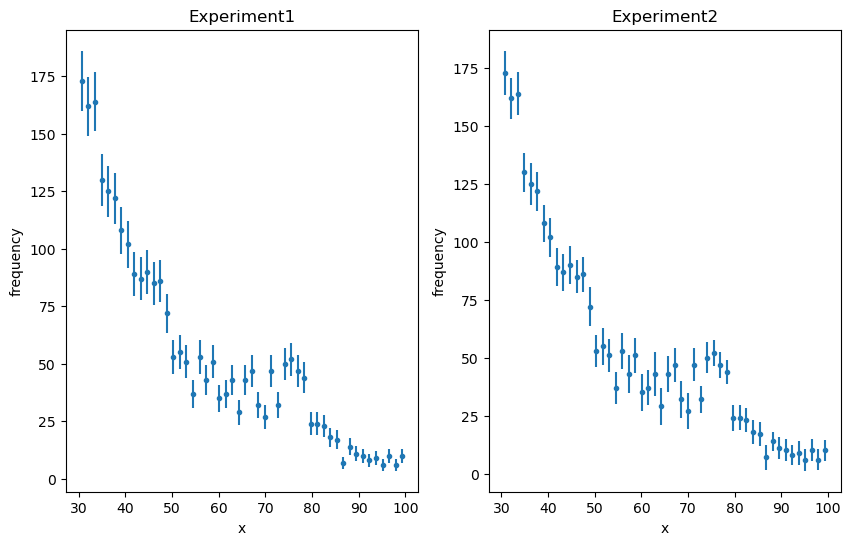

In [10]:
# Plot the histogram data with error bars
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

ax1.set_title('Experiment1')
ax1.set_xlabel('x')
ax1.set_ylabel('frequency')

ax2.set_title('Experiment2')
ax2.set_xlabel('x')
ax2.set_ylabel('frequency')

ax1.errorbar(x1, y1, yerr=e1, fmt='.')
ax2.errorbar(x1, y1, yerr=e2, fmt='.')


You job for this project will be to develop a simultaneous fit for the two histograms using minuit.  See this week's exercise description for more details.

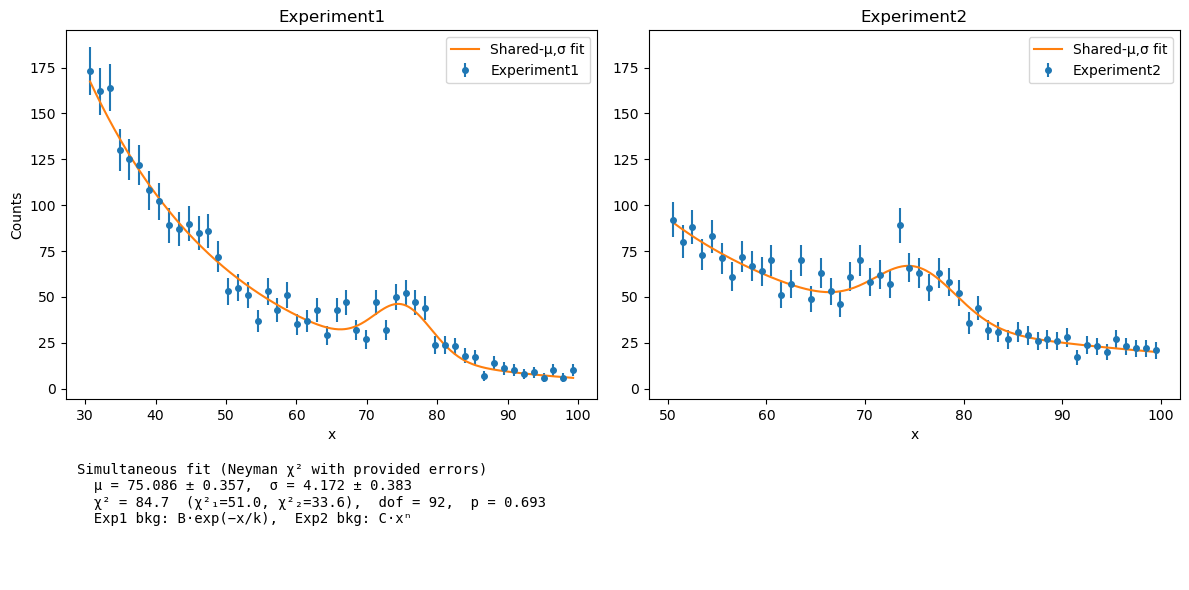

mu = 75.0862 ± 0.357234
sig = 4.17248 ± 0.382756
chi2 = 84.672, dof = 92, p = 0.6935


In [19]:
from lmfit import minimize, Parameters
from scipy.stats import chi2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

def gauss(x, mu, sig):
    return np.exp(-0.5*((x - mu)/sig)**2)

def safe_pow(x, n):
    return np.exp(n * np.log(np.maximum(x, 1e-300)))

def m1(x, s1, mu, sig, b1, k1):
    return s1*gauss(x, mu, sig) + b1*np.exp(-x/k1)

def m2(x, s2, mu, sig, c2, n2):
    return s2*gauss(x, mu, sig) + c2*safe_pow(x, n2)

mask1 = (y1 > 0) & (e1 > 0)
mask2 = (y2 > 0) & (e2 > 0)
x1u, n1u, s1u = x1[mask1], y1[mask1], e1[mask1]
x2u, n2u, s2u = x2[mask2], y2[mask2], e2[mask2]
s1u = np.maximum(s1u, 1e-6)
s2u = np.maximum(s2u, 1e-6)

mu0 = float(np.average(np.r_[x1u, x2u], weights=np.r_[n1u, n2u]))
sig0 = 5.0
p = Parameters()
p.add('mu',  value=mu0)
p.add('sig', value=max(sig0, 1e-6), min=1e-6)
p.add('s1',  value=float(n1u.max()), min=0)
p.add('b1',  value=float(np.median(n1u)), min=0)
p.add('k1',  value=20.0, min=1e-6)
p.add('s2',  value=float(n2u.max()), min=0)
p.add('c2',  value=1.0, min=0)
p.add('n2',  value=-2.0)

def resid(pars):
    mu = pars['mu'].value; sig = pars['sig'].value
    s1v = pars['s1'].value; b1v = pars['b1'].value; k1v = pars['k1'].value
    s2v = pars['s2'].value; c2v = pars['c2'].value; n2v = pars['n2'].value
    r1 = (m1(x1u, s1v, mu, sig, b1v, k1v) - n1u) / s1u
    r2 = (m2(x2u, s2v, mu, sig, c2v, n2v) - n2u) / s2u
    r = np.concatenate([r1, r2]).astype(np.float64)
    r[~np.isfinite(r)] = 1e6
    return r

res = minimize(lambda _p: resid(_p), p, method='leastsq', max_nfev=2000)

chi2_tot = float(np.sum(res.residual**2))
ndf = (len(x1u) + len(x2u)) - len(res.var_names)
pval = float(chi2.sf(chi2_tot, ndf))

r1_only = res.residual[:len(x1u)]
r2_only = res.residual[len(x1u):]
chi2_1 = float(np.sum(r1_only**2))
chi2_2 = float(np.sum(r2_only**2))

xg1 = np.linspace(x1u.min(), x1u.max(), 400)
xg2 = np.linspace(x2u.min(), x2u.max(), 400)
mu = res.params['mu'].value; sig = res.params['sig'].value
s1v = res.params['s1'].value; b1v = res.params['b1'].value; k1v = res.params['k1'].value
s2v = res.params['s2'].value; c2v = res.params['c2'].value; n2v = res.params['n2'].value
fit1 = m1(xg1, s1v, mu, sig, b1v, k1v)
fit2 = m2(xg2, s2v, mu, sig, c2v, n2v)

if res.covar is not None:
    scale = chi2_tot/ndf
    names = list(res.var_names)
    i_mu  = names.index('mu')
    i_sig = names.index('sig')
    emu  = float(np.sqrt(res.covar[i_mu,  i_mu]  * scale))
    esig = float(np.sqrt(res.covar[i_sig, i_sig] * scale))
else:
    def r_mu(mu_, sig_):
        r1 = (m1(x1u, s1v, mu_, sig_, b1v, k1v) - n1u) / s1u
        r2 = (m2(x2u, s2v, mu_, sig_, c2v, n2v) - n2u) / s2u
        return np.concatenate([r1, r2])
    hmu = max(1e-4, 1e-3*abs(mu)); hsig = max(1e-4, 1e-3*abs(sig))
    r0 = r_mu(mu, sig)
    J = np.column_stack(((r_mu(mu+hmu, sig) - r0)/hmu, (r_mu(mu, sig+hsig) - r0)/hsig))
    cov = np.linalg.inv(J.T @ J) * (chi2_tot/ndf)
    emu = float(np.sqrt(cov[0,0])); esig = float(np.sqrt(cov[1,1]))

fig = plt.figure(figsize=(12, 6))
gs = GridSpec(2, 2, height_ratios=[3, 1], figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax1.errorbar(x1u, n1u, yerr=s1u, fmt='o', markersize=4, label='Experiment1')
ax1.plot(xg1, fit1, label='Shared-μ,σ fit')
ax1.set_title('Experiment1'); ax1.set_xlabel('x'); ax1.set_ylabel('Counts'); ax1.legend()

ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
ax2.errorbar(x2u, n2u, yerr=s2u, fmt='o', markersize=4, label='Experiment2')
ax2.plot(xg2, fit2, label='Shared-μ,σ fit')
ax2.set_title('Experiment2'); ax2.set_xlabel('x'); ax2.legend()

ax3 = fig.add_subplot(gs[1, :]); ax3.axis('off')
txt = (
    f"Simultaneous fit (Neyman χ² with provided errors)\n"
    f"  μ = {mu:.3f} ± {emu:.3f},  σ = {sig:.3f} ± {esig:.3f}\n"
    f"  χ² = {chi2_tot:.1f}  (χ²₁={chi2_1:.1f}, χ²₂={chi2_2:.1f}),  dof = {ndf},  p = {pval:.3g}\n"
    f"  Exp1 bkg: B·exp(−x/k),  Exp2 bkg: C·xⁿ\n"
)
ax3.text(0.01, 0.95, txt, va='top', family='monospace')

fig.tight_layout()
fig.savefig("ex2.pdf", bbox_inches='tight')
plt.show()

print(f"mu = {mu:.6g} ± {emu:.6g}")
print(f"sig = {sig:.6g} ± {esig:.6g}")
print(f"chi2 = {chi2_tot:.3f}, dof = {ndf}, p = {pval:.4g}")
